### Gather dependencies

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
# from sodapy import Socrata
from config import census_key
import pprint
import requests
import csv
import os
import scipy.stats as st

### Function for quickly calling a DataFrame

In [2]:
# Function for quickly assempling a DataFrame
def json_to_dataframe(response):
    return pd.DataFrame(response.json()[1:], columns=response.json()[0])

## Tom's work starts here

### Create DataFrame for CDC Data

In [3]:
cdc_data = pd.read_csv("../Project_1/cdc_data.csv")
cdc_data
cdc_df = pd.DataFrame(cdc_data)
cdc_df

# Choose the columns we want and rename anything that isn't clear
cdc_df = cdc_df[['case_month', 'res_state', 'res_county', 'age_group', 'sex', 'race', 'ethnicity', 'current_status']]
cdc_df = cdc_df.rename(columns={
    'res_state': 'State',
    'res_county': 'County',
    'ethnicity': 'Ethnicity',
    'current_status': 'Infection Status',
    'race':'Race'
})

# Drop "Unkown" race from dataset
cdc_df = cdc_df.loc[cdc_df['Race']!= 'Unknown', :]

# Set Infections to 1 and replace the various races with values that are compatible with the census data
cdc_df['Infections'] = 1
cdc_df['Race'] = cdc_df['Race'].replace('White', 'Caucasian')
cdc_df['Race'] = cdc_df['Race'].replace('Black', 'African American')
cdc_df['Race'] = cdc_df['Race'].replace('American Indian/Alaska Native', 'Native American')
cdc_df['Race'] = cdc_df['Race'].replace('Multiple/Other', 'Other')
cdc_df['Race'] = np.where(np.logical_and(cdc_df['Race'] == 'Caucasian', cdc_df['Ethnicity'] == 'Hispanic/Latino'), 'Hispanic', cdc_df['Race'])

# NOTE: It's not clear what happens with Hawaiian here. 

cdc_df.head()

,case_month,State,County,age_group,sex,Race,Ethnicity,Infection Status,Infections
0,2021-11,MN,STEELE,18 to 49 years,Male,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
2,2021-11,MN,STEARNS,50 to 64 years,Female,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
3,2020-05,MN,KANDIYOHI,18 to 49 years,Male,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
4,2021-05,MN,ANOKA,18 to 49 years,Male,NaN,NaN,Laboratory-confirmed case,1
5,2020-04,MN,CLAY,65+ years,Female,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1


### Drop NaN and compile totals by county and race

In [4]:
# Drop NaNs and then group by County and Race
cdc_df = cdc_df.dropna(how='any')
cdc_df = cdc_df[['County', 'Race', 'Infections']]
cdc_grouped_county = cdc_df.groupby(['County', 'Race'])
cdc_df = cdc_grouped_county.count()
cdc_df.reset_index(inplace=True)
cdc_df.head()


,County,Race,Infections
0,ANOKA,African American,2864
1,ANOKA,Asian,1732
2,ANOKA,Caucasian,24501
3,ANOKA,Hispanic,746
4,ANOKA,Native American,73


### Create poverty DataFrame based on US Census

In [5]:
# Poverty DataFrame By Race - 2020

url = "https://api.census.gov/data/2020/acs/acs5?get=NAME,B17001_002E,B17001A_002E,B17001B_002E,B17001C_002E,B17001D_002E,B17001E_002E,B17001F_002E,B17001G_002E,B17001H_002E,B17001I_002E&for=county:*&in=state:27&key={0}".format(census_key)
response = requests.request("GET", url)
response
poverty_df = json_to_dataframe(response)

# Split NAME into county & state
name = poverty_df['NAME'].str.split(",", n=1, expand=True)
COUNTY = poverty_df['County'] = name[0]
STATE = poverty_df['State'] = name[1]
poverty_df.drop(columns=["NAME"], inplace=True)
poverty_df['Caucasian2'] = poverty_df['B17001A_002E'].astype(int) - poverty_df['B17001I_002E'].astype(int)
poverty_df['Other'] = poverty_df['B17001F_002E'].astype(int) + poverty_df['B17001G_002E'].astype(int)

# Get the columns we want
poverty_df = poverty_df[['County', 'State','B17001_002E','Caucasian2', 'B17001B_002E','B17001C_002E','B17001D_002E','B17001E_002E','Other','B17001I_002E']]

# Rename columns to something intelligible
poverty_df = poverty_df.rename(columns={
    'B17001_002E':'Poverty Total',
    'Caucasian2':'Caucasian',
    'B17001B_002E':'African American',
    'B17001C_002E':'Native American',
    'B17001D_002E':'Asian',
    'B17001E_002E':'Hawaiian', # I had to change this from Native Hawaiian to Hawaiian for compatibility with the rest - Dom
    'B17001I_002E':'Hispanic' 
    })

# # Remove ...County from County in dataframe
poverty_df['County'] = poverty_df['County'].replace('County', '', regex=True)
# NOTE: The line above accidentally leaves a blank space at the end of these county names! That space caused a merge to fail
# on any of these counties because, for example, "AITKIN " is not the same as "AITKIN". 

# Remove any blank space that may be present at the begining or end of the county name
poverty_df['County'] = poverty_df['County'].str.strip()

# And then convert the county name to uppercase
poverty_df['County'] = poverty_df['County'].str.upper()

poverty_df['Year'] = 2020
#poverty_df.to_csv("../Project_1/population_in_poverty.csv")
poverty_df.head()



,County,State,Poverty Total,Caucasian,African American,Native American,Asian,Hawaiian,Other,Hispanic,Year
0,ANOKA,Minnesota,20270,11778,3697,327,953,0,1964,1551,2020
1,BECKER,Minnesota,3588,2296,17,709,45,0,381,140,2020
2,BELTRAMI,Minnesota,8167,3657,310,3056,39,0,734,371,2020
3,BENTON,Minnesota,3357,2605,333,19,73,0,205,122,2020
4,BIG STONE,Minnesota,596,596,0,0,0,0,0,0,2020


In [6]:
# Choose only the columns we need
poverty_df = poverty_df[['County', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Other', 'Hispanic']]
poverty_df.head()

,County,Caucasian,African American,Native American,Asian,Hawaiian,Other,Hispanic
0,ANOKA,11778,3697,327,953,0,1964,1551
1,BECKER,2296,17,709,45,0,381,140
2,BELTRAMI,3657,310,3056,39,0,734,371
3,BENTON,2605,333,19,73,0,205,122
4,BIG STONE,596,0,0,0,0,0,0


In [7]:
# Use melt to convert this into a format similar to the CDC data
poverty_df = poverty_df.melt(id_vars='County', value_vars=['Caucasian', 'African American', 'Native American', 'Asian', \
                                                    'Hawaiian', 'Other', 'Hispanic'], \
                                                     var_name='Race', value_name='Poverty')
poverty_gb = poverty_df.groupby(['County', 'Race'])
poverty_df = poverty_gb.sum()
poverty_df.reset_index(inplace=True)
poverty_df.head()

,County,Race,Poverty
0,AITKIN,African American,13
1,AITKIN,Asian,0
2,AITKIN,Caucasian,1711
3,AITKIN,Hawaiian,0
4,AITKIN,Hispanic,45


### Create population DataFrame by county and race

In [8]:
# Population by county, by race
url = "https://api.census.gov/data/2020/acs/acs5?get=NAME,B03002_001E,B03002_003E,B03002_004E,B03002_005E,B03002_006E,B03002_007E,B03002_008E,B03002_009E,B03002_012E&for=county:*&in=state:27&key={0}".format(census_key)


response = requests.request("GET", url)
response
response_df = json_to_dataframe(response)
response_df = response_df.rename(columns={
    'B03002_001E': 'Population Total',
    'B03002_003E': 'Caucasian',
    'B03002_004E': 'African American',
    'B03002_005E': 'Native American',
    'B03002_006E': 'Asian',
    'B03002_007E': 'Hawaiian',
    'B03002_012E': 'Hispanic'
})
response_df['Other'] = response_df['B03002_008E'].astype(int) + response_df['B03002_009E'].astype(int)
mn_pop_df = response_df

# Split NAME into county & state
name = mn_pop_df['NAME'].str.split(",", n=1, expand=True)
COUNTY = mn_pop_df['County']=name[0]
STATE = mn_pop_df['State']=name[1]
mn_pop_df.drop(columns=["NAME"], inplace=True)

# # Remove ...County from County in dataframe
mn_pop_df['County'] = mn_pop_df['County'].replace('County', '', regex=True)
# NOTE: The line above accidentally leaves a blank space at the end of these county names! That space caused a merge to fail
# on any of these counties because, for example, "AITKIN " is not the same as "AITKIN". 

# Remove any blank space that may be present at the begining or end of the county name
mn_pop_df['County'] = mn_pop_df['County'].str.strip()

# # Upper case for County
mn_pop_df['County'] = mn_pop_df['County'].str.upper()
mn_pop_df = mn_pop_df[['County', 'Population Total', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Hispanic', 'Other']]
mn_pop_df.to_csv("../Project_1/mn_population by race.csv")
mn_pop_df.head()


,County,Population Total,Caucasian,African American,Native American,Asian,Hawaiian,Hispanic,Other
0,ANOKA,353775,283436,23534,1788,16082,86,16769,12080
1,BECKER,34227,29290,146,1938,209,6,738,1900
2,BELTRAMI,46784,33506,399,8920,295,36,1114,2514
3,BENTON,40476,35979,1876,49,378,0,1086,1108
4,BIG STONE,4974,4787,3,3,0,0,102,79


### Coordinates for heat map -- if time permits

In [9]:
# Get the coordinates of counties in MN
url = "https://en.wikipedia.org/wiki/User:Michael_J/County_table"

table = pd.read_html(url)
df = table[0]
Counties = df.loc[df['State'] == "MN", : ]
counties_df = Counties[['County [2]', 'Latitude', 'Longitude']]
counties_df.head()

,County [2],Latitude,Longitude
1314,Aitkin,+46.602446°,–93.419760°
1315,Anoka,+45.274110°,–93.242723°
1316,Becker,+46.937629°,–95.741757°
1317,Beltrami,+47.878825°,–94.986698°
1318,Benton,+45.701227°,–94.001440°


In [10]:
# Choose only the columns we need
mn_pop_df = mn_pop_df[['County', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Other', 'Hispanic']]
mn_pop_df.head()


,County,Caucasian,African American,Native American,Asian,Hawaiian,Other,Hispanic
0,ANOKA,283436,23534,1788,16082,86,12080,16769
1,BECKER,29290,146,1938,209,6,1900,738
2,BELTRAMI,33506,399,8920,295,36,2514,1114
3,BENTON,35979,1876,49,378,0,1108,1086
4,BIG STONE,4787,3,3,0,0,79,102


In [11]:
# Use melt to convert this into a format similar to the CDC data
pop_df = mn_pop_df.melt(id_vars='County', value_vars=['Caucasian', 'African American', 'Native American', 'Asian', \
                                                      'Hawaiian', 'Other', 'Hispanic'], \
                                                      var_name='Race', value_name='Population')
pop_gb = pop_df.groupby(['County', 'Race'])
pop_df = pop_gb.sum()
pop_df.reset_index(inplace=True)
pop_df.head()

,County,Race,Population
0,AITKIN,African American,61
1,AITKIN,Asian,40
2,AITKIN,Caucasian,14831
3,AITKIN,Hawaiian,9
4,AITKIN,Hispanic,216


### Merge the datasets

In [12]:
merged_df = pd.merge(pop_df, poverty_df, on=['County', 'Race'])
merged_df = pd.merge(merged_df, cdc_df, on=['County', 'Race'])
merged_df.head()

,County,Race,Population,Poverty,Infections
0,ANOKA,African American,23534,3697,2864
1,ANOKA,Asian,16082,953,1732
2,ANOKA,Caucasian,283436,11778,24501
3,ANOKA,Hispanic,16769,1551,746
4,ANOKA,Native American,1788,327,73


In [13]:
# Edited merge_df for nan infections to be 0
merged_df = pd.merge(pop_df, poverty_df, on=['County', 'Race'])
merged_df = pd.merge(merged_df, cdc_df, on=['County', 'Race'], how = "left")
merged_df["Infections"] = merged_df["Infections"].fillna(0)

# Convert all numerical values in merged_df from strings to int
merged_df["Population"] = merged_df["Population"].astype(int)
merged_df["Poverty"] = merged_df["Poverty"].astype(int)
merged_df["Infections"] = merged_df["Infections"].astype(int)

merged_df.head()

,County,Race,Population,Poverty,Infections
0,AITKIN,African American,61,13,0
1,AITKIN,Asian,40,0,0
2,AITKIN,Caucasian,14831,1711,0
3,AITKIN,Hawaiian,9,0,0
4,AITKIN,Hispanic,216,45,0


In [14]:
# Convert all non-caucasian races to "non-caucasian"
#non_caucasian = ['African American', 'Hispanic', 'Asian', 'Native American', 'Hawaiian', 'Other']
merged_df['Two-Races']=["Non-Caucasian" if (x=="African American" or x=="Asian" or x=="Hispanic" or x=="Native American"\
    or x=="Hawaiian" or x=="Other") else "Caucasian" for x in merged_df['Race']]
merged_df

,County,Race,Population,Poverty,Infections,Two-Races
0,AITKIN,African American,61,13,0,Non-Caucasian
1,AITKIN,Asian,40,0,0,Non-Caucasian
2,AITKIN,Caucasian,14831,1711,0,Caucasian
3,AITKIN,Hawaiian,9,0,0,Non-Caucasian
4,AITKIN,Hispanic,216,45,0,Non-Caucasian
...,...,...,...,...,...,...
604,YELLOW MEDICINE,Caucasian,8725,722,0,Caucasian
605,YELLOW MEDICINE,Hawaiian,0,0,0,Non-Caucasian
606,YELLOW MEDICINE,Hispanic,468,53,0,Non-Caucasian
607,YELLOW MEDICINE,Native American,229,30,0,Non-Caucasian


In [15]:
two_races_df = merged_df[['County', 'Two-Races', 'Population', 'Poverty', 'Infections']]
two_races_df.head()

,County,Two-Races,Population,Poverty,Infections
0,AITKIN,Non-Caucasian,61,13,0
1,AITKIN,Non-Caucasian,40,0,0
2,AITKIN,Caucasian,14831,1711,0
3,AITKIN,Non-Caucasian,9,0,0
4,AITKIN,Non-Caucasian,216,45,0


### Poverty Rates

In [16]:
pd.set_option('mode.chained_assignment', None)
poverty_rate = []
infection_rate = []

i = 0
while i < len(two_races_df):
    if merged_df["Population"][i] == 0:
        poverty_rate.append(0)
        infection_rate.append(0)
    else: 
        poverty_rate.append(two_races_df["Poverty"][i] / two_races_df["Population"][i])
        infection_rate.append(two_races_df["Infections"][i] / two_races_df["Population"][i])
    i += 1
    
two_races_df["Poverty Rate"] = poverty_rate
two_races_df["Infection Rate"] = infection_rate


In [17]:
# Population, poverty, and infection totals
row_sum = two_races_df.iloc[:,2:5].sum()

two_races_df.loc['Total'] = row_sum
two_races_df.fillna('')
two_races_df.loc['Total', 'County']=''
two_races_df.loc['Total', 'Two-Races'] = ''
two_races_df.loc['Total', 'Poverty Rate'] = ''
two_races_df.loc['Total', 'Infection Rate'] = ''
two_races_df


,County,Two-Races,Population,Poverty,Infections,Poverty Rate,Infection Rate
0,AITKIN,Non-Caucasian,61.0,13.0,0.0,0.213115,0.0
1,AITKIN,Non-Caucasian,40.0,0.0,0.0,0.0,0.0
2,AITKIN,Caucasian,14831.0,1711.0,0.0,0.115366,0.0
3,AITKIN,Non-Caucasian,9.0,0.0,0.0,0.0,0.0
4,AITKIN,Non-Caucasian,216.0,45.0,0.0,0.208333,0.0
...,...,...,...,...,...,...,...
605,YELLOW MEDICINE,Non-Caucasian,0.0,0.0,0.0,0.0,0.0
606,YELLOW MEDICINE,Non-Caucasian,468.0,53.0,0.0,0.113248,0.0
607,YELLOW MEDICINE,Non-Caucasian,229.0,30.0,0.0,0.131004,0.0
608,YELLOW MEDICINE,Non-Caucasian,236.0,56.0,0.0,0.237288,0.0


In [18]:
# Caucasian statistical summary

caucasian = two_races_df.loc[two_races_df['Two-Races'] == 'Caucasian']
caucasian_pop = caucasian.groupby(['Two-Races'])['Population'].agg(['mean', 'median', 'var', 'std', 'sem']).astype(float).round(2)
caucasian_inf = caucasian.groupby(['Two-Races'])['Infections'].agg(['mean', 'median', 'var', 'std', 'sem']).astype(float).round(2)
caucasian_pov = caucasian.groupby(['Two-Races'])['Poverty'].agg(['mean', 'median', 'var', 'std', 'sem']).astype(float).round(2)



In [19]:
# Non-Caucasian statistical summary

non_caucasian = two_races_df.loc[two_races_df['Two-Races'] == 'Non-Caucasian']
non_caucasian_pop = non_caucasian.groupby(['Two-Races'])['Population'].agg(['mean', 'median', 'var', 'std', 'sem']).astype(float).round(2)
non_caucasian_pov = non_caucasian.groupby(['Two-Races'])['Poverty'].agg(['mean', 'median', 'var', 'std', 'sem']).astype(float).round(2)
non_caucasian_inf = non_caucasian.groupby(['Two-Races'])['Infections'].agg(['mean', 'median', 'var', 'std', 'sem']).astype(float).round(2)

print(non_caucasian_pop)
print(non_caucasian_pov)
print(non_caucasian_inf)



                  mean  median           var       std     sem
Two-Races                                                     
Non-Caucasian  2256.08   185.5  1.175087e+08  10840.14  474.46
                 mean  median        var     std     sem
Two-Races                                               
Non-Caucasian  471.68    38.0  6301112.8  2510.2  109.87
                 mean  median        var     std    sem
Two-Races                                              
Non-Caucasian  145.72     0.0  939979.67  969.53  42.43


In [24]:
# Metro area counties
merged_df['Metro-Non']=["Metro" if (x=="RAMSEY" or x=="DAKOTA" or x=="HENNEPIN" or x=="ANOKA"\
    or x=="SCOTT" or x=="WASHINGTON" or x=="CARVER") else "Non_Metro" for x in merged_df['County']]
merged_df_metro = merged_df[['Metro-Non', 'County', 'Two-Races', 'Population', 'Poverty', 'Infections']]
merged_df_metro



,Metro-Non,County,Two-Races,Population,Poverty,Infections
0,Non_Metro,AITKIN,Non-Caucasian,61,13,0
1,Non_Metro,AITKIN,Non-Caucasian,40,0,0
2,Non_Metro,AITKIN,Caucasian,14831,1711,0
3,Non_Metro,AITKIN,Non-Caucasian,9,0,0
4,Non_Metro,AITKIN,Non-Caucasian,216,45,0
...,...,...,...,...,...,...
604,Non_Metro,YELLOW MEDICINE,Caucasian,8725,722,0
605,Non_Metro,YELLOW MEDICINE,Non-Caucasian,0,0,0
606,Non_Metro,YELLOW MEDICINE,Non-Caucasian,468,53,0
607,Non_Metro,YELLOW MEDICINE,Non-Caucasian,229,30,0


In [93]:
pd.set_option('mode.chained_assignment', None)
poverty_rate = []
infection_rate = []

i = 0
while i < len(merged_df_metro):
    if merged_df_metro["Population"][i] == 0:
        poverty_rate.append(0)
        infection_rate.append(0)
    else: 
        poverty_rate.append(merged_df_metro["Poverty"][i] / merged_df_metro["Population"][i])
        infection_rate.append(merged_df_metro["Infections"][i] / merged_df_metro["Population"][i])
    i += 1
    
merged_df_metro["Poverty Rate"] = poverty_rate
merged_df_metro["Infection Rate"] = infection_rate

merged_df_metro.head()

,Metro-Non,County,Two-Races,Population,Poverty,Infections,Poverty Rate,Infection Rate
0,Non_Metro,AITKIN,Non-Caucasian,61,13,0,0.213115,0.0
1,Non_Metro,AITKIN,Non-Caucasian,40,0,0,0.000000,0.0
2,Non_Metro,AITKIN,Caucasian,14831,1711,0,0.115366,0.0
3,Non_Metro,AITKIN,Non-Caucasian,9,0,0,0.000000,0.0
4,Non_Metro,AITKIN,Non-Caucasian,216,45,0,0.208333,0.0


0        Metro
1    Non_Metro
Name: Metro-Non, dtype: object


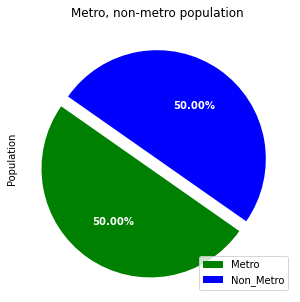

In [112]:
merged_df_metro_meta = merged_df_metro[['Metro-Non', 'Population']].groupby('Metro-Non')
metro_df = merged_df_metro_meta.sum().reset_index()
metro_df
by_metro = metro_df['Population'].value_counts()
labels = metro_df['Metro-Non']
colors = ['green', 'blue']
explode=(0.11, 0)
print(labels)
by_metro.plot(
    kind="pie",
    figsize=(5,5),
    colors=colors,
    autopct='%1.2f%%',
    explode=explode,
    startangle=145,
    textprops={'color':'white', 'weight':'bold'}

)
plt.title("Metro, non-metro population")
plt.legend(labels, loc=4)
plt.show()
